In [1]:
import numpy as np
import matplotlib.pyplot as plt
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

In [2]:
def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """
    Write an animated GIF to file using matplotlib and ImageMagick.

    Inputs:

        draw_function (callable) The function to call, once per frame,
          to render to the current matplotlib figure. This function's call
          signature must be

            draw_function(current_frame_number, total_frame_count)

          The first frame is 0 and the last frame is total_frame_count-1.

        frames (int) The number of frames to generate.

        interval (float) The number of milliseconds to wait between frames
          in the animation. Set this to 40 for a fairly standard frame rate
          of 25fps (1 second / 40 (milliseconds per frame) = 25 frames per
          second).

        filename (str) The path to the file to write to. If none is provided,
          the animation will be written to a random filename, prefixed with
          "animate_" in the current directory. Default: None.

        verbose (bool) Whether to print the current frame number to the
          console as the animation is being created. This will clear other
          console output. Default: False.

        figure_params (dict) The keyword arguments to pass to matplotlib
          when creating a new figure for this animation. Use it to set the
          figure size and other figure properties. Default: None.

    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    from matplotlib import pyplot, animation
    from IPython.display import HTML, display, clear_output, Image
    import random

    if filename is None:
        filename = 'animate_%06i.gif' % random.randint(0, 999999)

    if figure_params is None:
        figure_params = {}
    figure = pyplot.figure(**figure_params)

    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)

    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    anim.save(filename, writer='imagemagick')
    pyplot.close()

    file_ = open(filename,'rb')
    with file_ as f:
        return display(Image(data=f.read(), format='png'))

In [3]:
class IsingSimulation:

    J = 6.34369e-21  # Interaction constant for iron [Joule]
    kB = 1.38065e-23  # Boltzmann constant [Joule / Kelvin]

    def __init__(self, size=100, temperature=300, speedup=None):
        '''
        Initialize a new Ising simulation.

        Parameters:

            size (int) The number of cells along each side of the
              square grid. Default: 100.

            temperature (float) The temperature at which to run the
              simulation, measured in Kelvin. The Curie temperature
              of iron is at 1043 K. Default: 300 (approximately room
              temperature).

            speedup (int) The number of cell flips to do per call to
              the update() method. Default: size ** 2.
        '''
        self.size = size
        self.set_temperature(temperature)
        if speedup is None:
            speedup = self.size ** 2
        self.speedup = speedup

        # Set random initial state
        self.state = np.random.choice(
            [-1, 1], size=(self.size, self.size))
        self.step = 0
        self.total_flips = 0
        self.history = {
            'step': [],
            'magnetism': []}

    def set_temperature(self, temp):
        '''
        Set the temperature of the model in Kelvin.
        '''
        self.temperature = float(temp)
        self.cluster_prob = 1 - np.exp(-2 * self.J / (self.temperature * self.kB))

    def energy(self):
        '''
        Compute the energy of the current state of the model.
        '''
        return -self.J * (self.state * (
            np.roll(self.state, 1, axis=0) +
            np.roll(self.state, 1, axis=1))).sum()

    def average_magnetism(self):
        '''
        Compute the average per-cell magnetism of the current state
        of the model.
        '''
        return self.state.mean()

    def update(self, algo="Wolff"):
        if algo == "MetroHast":
            # Flip the signs of self.speedup cells
            for _ in range(self.speedup):
                # Pick a random cell to flip
                x, y = np.random.randint(self.size, size=2)
                # Change in energy from current state to next state if we flip
                delta_E = (
                    2 * self.J * self.state[x, y] * (
                        self.state[(x + 1) % self.size, y] +
                        self.state[(x - 1) % self.size, y] +
                        self.state[x, (y + 1) % self.size] +
                        self.state[x, (y - 1) % self.size]))
                # Log probability of changing state
                log_p = -delta_E / (self.temperature * self.kB)
                # Flip cell with probability exp(log_p)
                if np.log(np.random.uniform(0, 1)) < log_p:
                    self.state[x, y] = -self.state[x, y]

            self.step += self.speedup
            self.history['step'].append(self.step)
            self.history['magnetism'].append(self.state.mean())

        elif algo == "Wolff":
            '''
            Do a single cluster update of the model state.
            '''
            # Pick a random cell to start the cluster
            i, j = np.random.randint(self.size, size=2)
            cell_value = self.state[i, j]
            cluster = {(i, j)}
            pocket = [(i, j)]

            while len(pocket) > 0:
                # Get a random cell from the pocket
                i, j = pocket.pop(np.random.randint(0, len(pocket)))
                # Check whether to add any of the cell's neighbors to the cluster
                for u, v in [
                    ((i - 1) % self.size, j),
                    ((i + 1) % self.size, j),
                    (i, (j - 1) % self.size),
                    (i, (j + 1) % self.size)
                ]:
                    if (
                        (self.state[u, v] == cell_value) and
                        ((u, v) not in cluster) and
                        (np.random.uniform(0, 1) < self.cluster_prob)
                    ):
                        pocket.append((u, v))
                        cluster.add((u, v))
            # Flip all cells in the cluster
            for (i, j) in cluster:
                self.state[i, j] = -cell_value
            self.step += 1
            self.total_flips += len(cluster)

    def display_state(self):
        # Plot current state
        plt.imshow(self.state, vmin=-1, vmax=+1, interpolation='nearest')
        plt.title('Updates: ' + str(self.step) + '. Flips: ' + str(self.total_flips) + '. M = ' + str(self.average_magnetism()))

    def display_history(self):
        # Plot history of average magnetism
        step = np.array(self.history['step'])
        for y in [-1, 0, 1]:
            plt.plot([step[0], step[-1]], [y, y], 'k:')
        plt.plot(step, self.history['magnetism'], 'k-')
        plt.xlabel('step')
        plt.ylabel('average magnetism')
        plt.title('Temperature: ' + str(self.temperature) + ' K')

In [4]:
def ising_gif_animation(temperature, size, frames, steps_per_frame=None):
    sim = IsingSimulation(size, temperature, speedup=steps_per_frame)

    def animate(frame, total_frames):
        sim.update("MetroHast")
        sim.display_state()

    animation = make_animation(
        animate, frames=frames, interval=10000 // frames,
        verbose=True, filename = f"ising_{temperature}K.gif", figure_params={'figsize': (4, 4)})

    plt.figure(figsize=(8,4))
    sim.display_history()

    return animation

def ising_animation(temperature, size, frames, steps_per_frame=None):
    sim = IsingSimulation(size, temperature, speedup=steps_per_frame)

    for i in range(frames):
        sim.update("MetroHast")
        plt.figure(figsize=(4,4))
        sim.display_state()
    plt.figure(figsize=(8,4))
    sim.display_history()

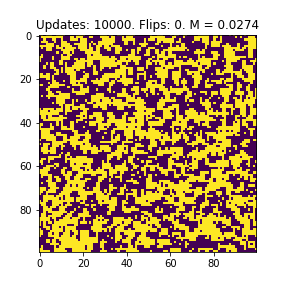

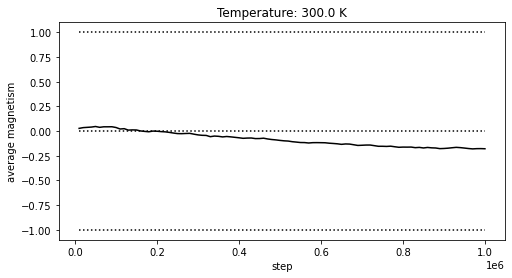

In [5]:
ising_gif_animation(temperature=300, size=100, frames=100)

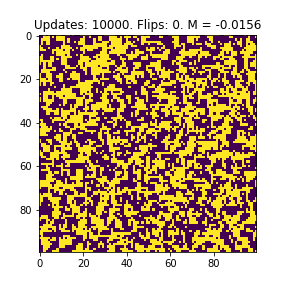

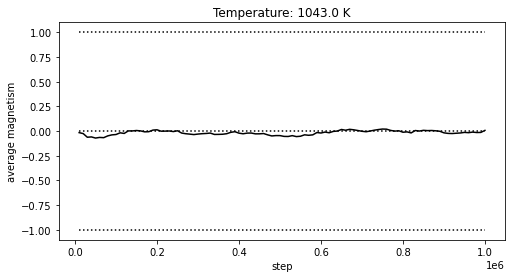

In [ ]:
ising_gif_animation(temperature=1043, size=100, frames=100)

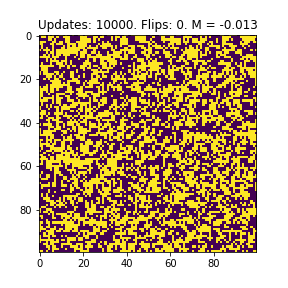

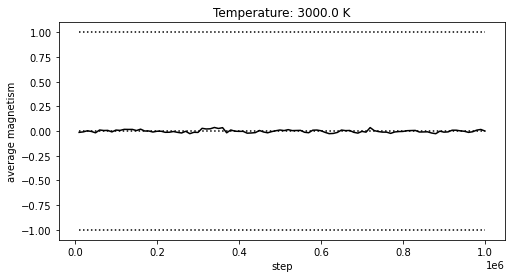

In [ ]:
ising_gif_animation(temperature=3000, size=100, frames=100)

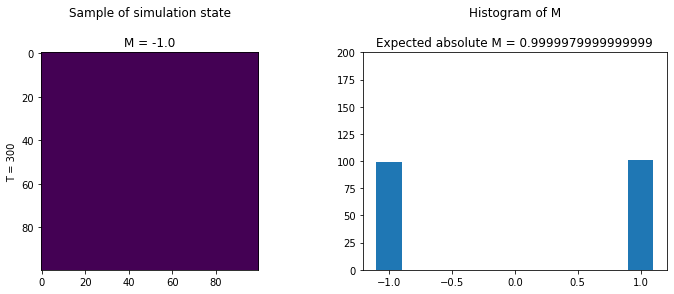

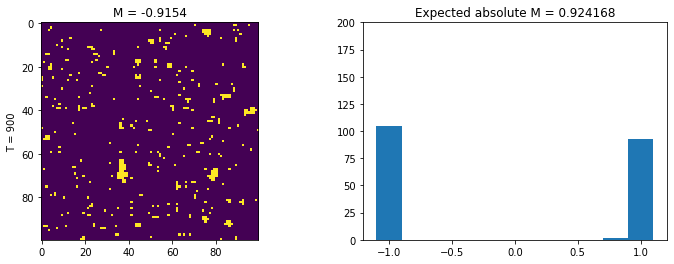

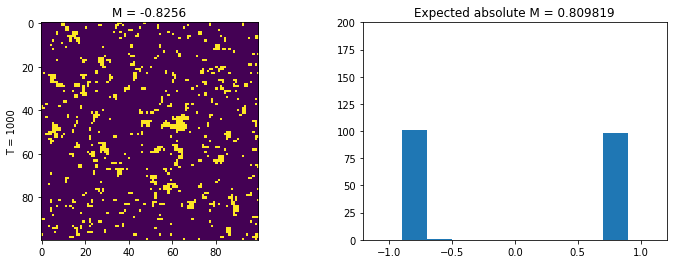

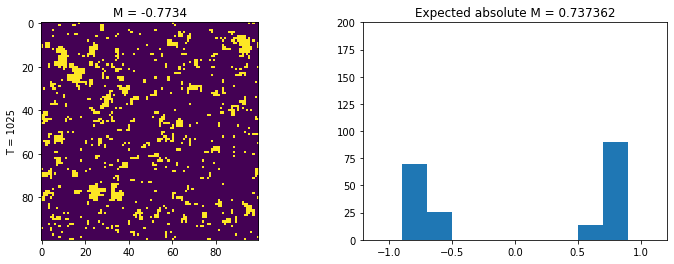

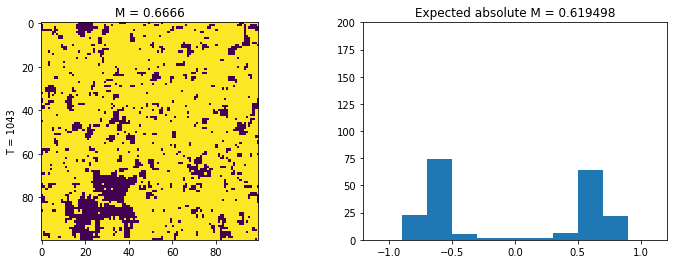

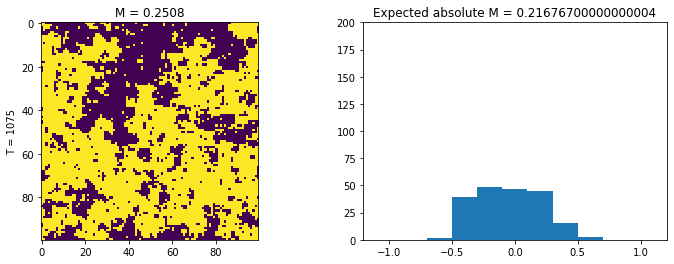

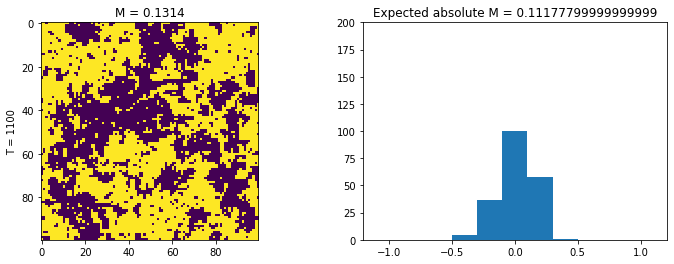

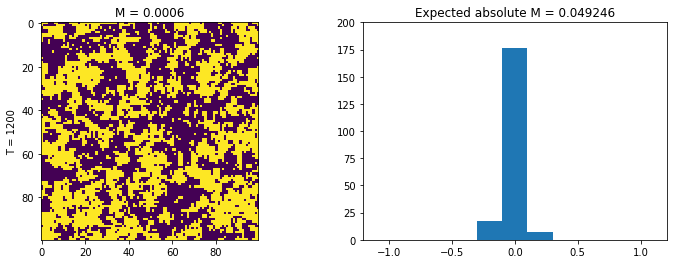

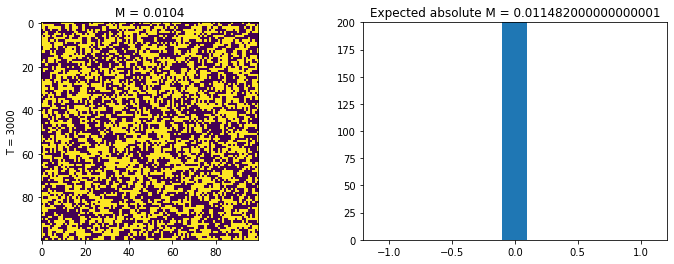

In [ ]:
# NOTE: This cell takes about 20 minutes to run

size = 100
number_of_samples = 200
burn_in_passes = 10
passes_between_samples = 3
first_plot = True
for temperature in [300, 900, 1000, 1025, 1043, 1075, 1100, 1200, 3000]:
    sim = IsingSimulation(size, temperature)
    while sim.total_flips < burn_in_passes * size**2:
        sim.update()
    average_magnetism = []
    for _ in range(number_of_samples):
        start = sim.total_flips
        stop = start + (passes_between_samples + np.random.randint(2)) * size**2
        while sim.total_flips < stop:
            sim.update()
        average_magnetism.append(sim.average_magnetism())

    # Plot a sample from the simulation state
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sim.display_state()
    title = f'M = {sim.average_magnetism()}'
    if first_plot:
        title = 'Sample of simulation state\n\n' + title
    plt.title(title)
    plt.ylabel(f'T = {temperature}')

    # Plot a histogram of the distribution over average magnetism from the experiment
    plt.subplot(1, 2, 2)
    plt.hist(average_magnetism, range=[-1.1, 1.1], bins=11)
    plt.ylim(0, number_of_samples)
    title = f'Expected absolute M = {np.mean(np.fabs(average_magnetism))}'
    if first_plot:
        title = 'Histogram of M\n\n' + title
    plt.title(title)

    plt.show()
    first_plot = False

In [ ]:
# NOTE: This cell takes about 13 minutes to run

size = 100
temperatures = np.linspace(300, 1500, 13)
burn_in_passes = 10
passes_between_samples = 3
samples = 100

results = []
for i in range(len(temperatures)):
    sim = IsingSimulation(size, temperatures[i])
    while sim.total_flips < burn_in_passes * size**2:
        sim.update()
    m_samples = []
    for _ in range(samples):
        start = sim.total_flips
        stop = start + passes_between_samples * size**2
        while sim.total_flips < stop:
            sim.update()
        m_samples.append(abs(sim.average_magnetism()))
    results.append(np.mean(m_samples))

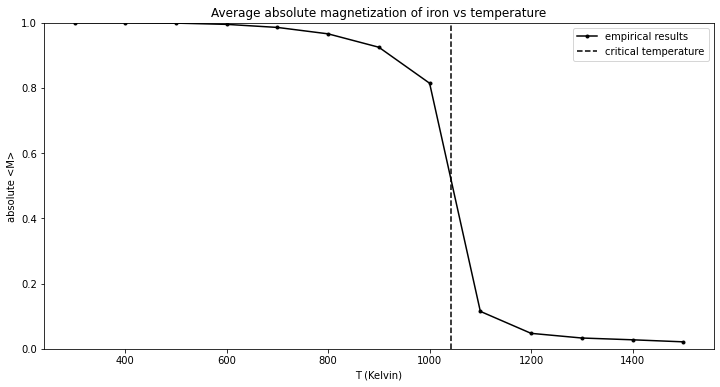

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(temperatures, results, 'k.-', label='empirical results')
plt.axvline(1043, color='k', linestyle='--', label='critical temperature')
plt.ylim(0, 1)
plt.title('Average absolute magnetization of iron vs temperature')
plt.xlabel('T (Kelvin)')
plt.ylabel('absolute <M>')
plt.legend()
plt.show()